# The Server Runs the Testing Process on the Plain Testing Dataset

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import h5py
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')

## Plotting the training results

In [3]:
df = pd.read_csv('outputs/loss_and_acc_8192.csv')
train_losses = df['train_losses']
train_accs = df['train_accs']

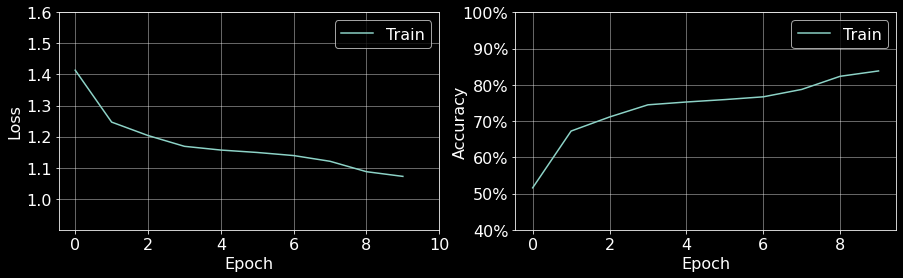

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

ax[0].plot(train_losses)
ax[0].set_xticks([0, 2, 4, 6, 8, 10])
ax[0].set_xlabel('Epoch', size=16)
ax[0].set_ylabel('Loss', size=16)
ax[0].set_ylim(0.9, 1.1)
ax[0].set_yticks([1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6])
ax[0].grid(alpha=0.5)
ax[0].tick_params(labelsize=16)
ax[0].legend(['Train', 'Test'], loc='upper right', fontsize=16)

ax[1].set_ylim(0.7, 1.0)
ax[1].set_yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
ax[1].plot(train_accs)
yt = ax[1].get_yticks()
ax[1].set_yticklabels(['{:,.0%}'.format(x) for x in yt])
ax[0].set_xticks([0, 2, 4, 6, 8, 10])
ax[1].set_xlabel('Epoch', size=16)
ax[1].set_ylabel('Accuracy', size=16, labelpad=-5)
ax[1].grid(alpha=0.5)
ax[1].tick_params(labelsize=16)
ax[1].legend(['Train', 'Test'], loc='upper right', fontsize=16)

## Dataset

In [5]:
class ECG(Dataset):
    """The class used by the client to load the dataset

    Args:
        Dataset ([type]): [description]
    """
    def __init__(self, train=True):
        if train:
            with h5py.File('./data/train_ecg.hdf5', 'r') as hdf:
                self.x = hdf['x_train'][:]
                self.y = hdf['y_train'][:]
        else:
            with h5py.File('./data/test_ecg.hdf5', 'r') as hdf:
                self.x = hdf['x_test'][:]
                self.y = hdf['y_test'][:]
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return torch.tensor(self.x[idx], dtype=torch.float), torch.tensor(self.y[idx])

In [6]:
batch_size = 4
test_dataset = ECG(train=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [7]:
x_test, y_test = next(iter(test_loader))
print(x_test.size())
print(y_test.size())
total_batch = len(test_loader)
print(total_batch)

torch.Size([4, 1, 128])
torch.Size([4])
3312


## Loading the trained model

In [8]:
client = torch.load('weights/trained_client_256_8192.pth')
server = torch.load('weights/trained_server_256_8192.pth')

class ECGModel(nn.Module):
    def __init__(self) -> None:
        super(ECGModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, 
                                out_channels=16, 
                                kernel_size=7, 
                                padding=3,
                                stride=1)  # 128 x 16
        self.relu1 = nn.LeakyReLU()
        self.pool1 = nn.MaxPool1d(2)  # 64 x 16
        self.conv2 = nn.Conv1d(in_channels=16, 
                                out_channels=8, 
                                kernel_size=5, 
                                padding=2)  # 64 x 8
        self.relu2 = nn.LeakyReLU()
        self.pool2 = nn.MaxPool1d(2)  # 32 x 8 = 256
        
        self.linear = nn.Linear(in_features=256,
                                out_features=5)
        self.softmax = nn.Softmax(dim=1)

        self.load_weights()

    def load_weights(self):
        self.conv1.weight.data = client["conv1.weight"]
        self.conv1.bias.data = client["conv1.bias"]
        self.conv2.weight.data = client["conv2.weight"]
        self.conv2.bias.data = client["conv2.bias"]
        self.linear.weight.data = server["W"]
        self.linear.bias.data = server["b"]

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(-1, 256)
        x = self.linear(x)
        x = self.softmax(x)
        return x

In [9]:
model = ECGModel()

## The testing loop

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f'device: {torch.cuda.get_device_name(0)}')

device: NVIDIA GeForce GTX 1070 Ti


In [11]:
def test(model):
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        test_loss = 0.0
        correct, total = 0, 0
        for _, batch in enumerate(test_loader):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            test_loss += loss.item()
            correct += torch.sum(y_hat.argmax(dim=1) == y).item()
            total += len(y)
    print(f"test_loss: {(test_loss/len(test_loader)):.4f}, "
          f"test_acc: {((correct/total)*100):.2f}")

test(model.to(device))

test_loss: 1.0578, test_acc: 85.31
